In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

print("Path to dataset files:", path)

print(path)

Path to dataset files: C:\Users\jonathanle\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2
C:\Users\jonathanle\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


<PIL.JpegImagePlugin.JpegImageFile image mode=L size=2090x1858 at 0x146459776A0>


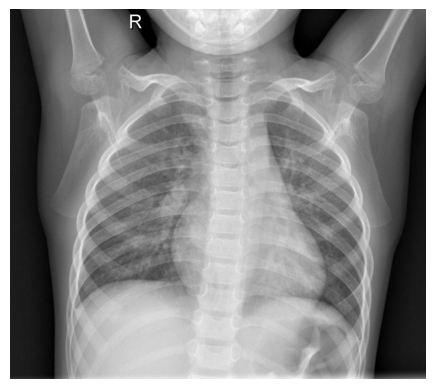

(2090, 1858)


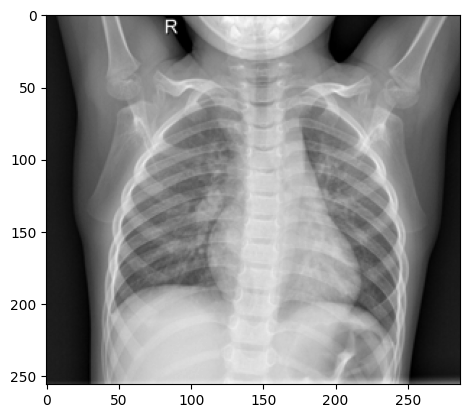

In [11]:
from PIL import Image
import os


import matplotlib.pyplot as plt

image = Image.open(os.path.join(path, "chest_xray/train/NORMAL/IM-0115-0001.jpeg"))


# TODO: Apply scaling ratio strategy to
end_height = 256
scale_factor = end_height / image.size[1]



img = image.resize((int(image.size[0] * scale_factor), 256))


print(image)


plt.imshow(image, cmap = 'gray')
plt.axis('off')  # This removes the axes
plt.show()

plt.imshow(img, cmap = 'gray')

# TODO: Transform the datase to

print(image.size)




In [12]:
import numpy as np
#Folder is either test, train, val
def load_images_from_folder(folder, image_size_x, image_size_y):

    #Define paths to normal and pneumonia
    normal =os.path.join(path, "chest_xray", folder, "NORMAL")
    pneumonia = os.path.join(path, "chest_xray", folder, "PNEUMONIA")

#For both normal and pneumonia, get images and label them
    x, y = [], []
    for img in os.listdir(normal):
        img_path = os.path.join(normal, img)
        try:
          img = Image.open(img_path)
          img = Image.open(img_path).convert("L") #Convert to grayscale
          img = img.resize((image_size_x, image_size_y))
          img_array = np.array(img) / 255.0 #Scale the image
          x.append(img_array)
          y.append(0)
        except Exception as e:
          print(f"Error loading image {img_path}: {e}")

    for img in os.listdir(pneumonia):
      img_path = os.path.join(pneumonia,img)
      try:
        img = Image.open(img_path)
        img = Image.open(img_path).convert("L") #Convert to grayscale
        img = img.resize((image_size_x, image_size_y))
        img_array = np.array(img) / 255.0 #Scale the image
        x.append(img_array)
        y.append(1)
      except Exception as e:
        print(f"Error loading image {img_path}: {e}")

    x = np.array(x)
    y = np.array(y)
    return x, y


In [13]:
end_height = 256
scale_factor = end_height / image.size[1]

end_width = int(image.size[0] * scale_factor)

x_train, y_train = load_images_from_folder("train", end_width, end_height)
x_test, y_test = load_images_from_folder("test", end_width, end_height)
x_val, y_val = load_images_from_folder("val", end_width, end_height)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_test.shape)

(5216, 256, 287)
(5216,)
(16, 256, 287)
(624, 256, 287)
(624,)


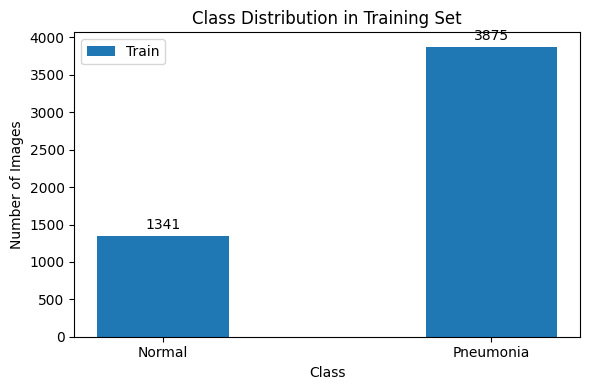

In [ ]:

# Count the occurrences of each label in the training set
train_normal = np.sum(y_train == 0)
train_pneumonia = np.sum(y_train == 1)

# Plot the counts for the training set
labels = ['Normal', 'Pneumonia']
train_counts = [train_normal, train_pneumonia]

x = np.arange(len(labels))  # The label locations

fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.4
rects1 = ax.bar(x, train_counts, bar_width, label='Train')

# Add some text for labels, title, and custom x-axis tick labels
ax.set_xlabel('Class')
ax.set_ylabel('Number of Images')
ax.set_title('Class Distribution in Training Set')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on top of bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(rects1)

plt.tight_layout()
plt.show()

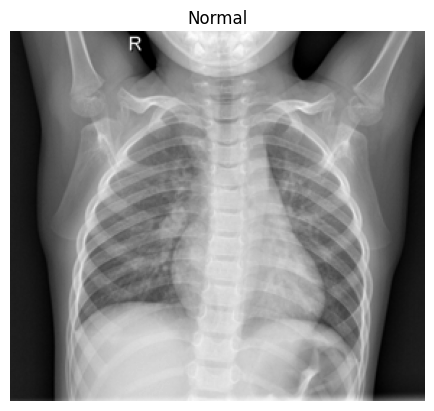

In [ ]:
# Display the first image in the training set with the appropriate label
plt.imshow(x_train[0], cmap='gray')  # Use 'gray' colormap for grayscale images
plt.axis('off')  # Hide axes for better visualization


plt.title(f"Normal")

plt.show()


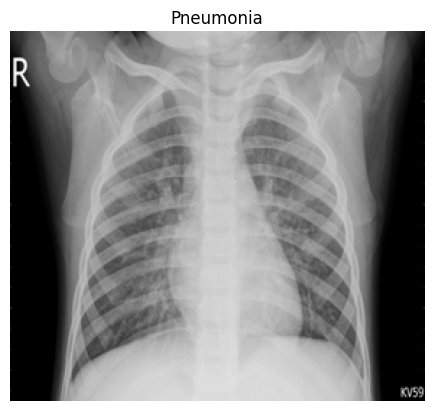

In [ ]:
# Display the first image in the training set with the appropriate label
plt.imshow(x_train[4000], cmap='gray')  # Use 'gray' colormap for grayscale images
plt.axis('off')  # Hide axes for better visualization


plt.title(f"Pneumonia")

plt.show()


In [ ]:
from tensorflow import keras
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_model(learning_rate=0.01):
  model = keras.models.Sequential()

  model.add(keras.layers.Flatten(input_shape = [end_width, end_height, 1]))
  model.add(keras.layers.Dense(300, activation = 'relu'))
  model.add(keras.layers.Dense(300, activation='relu'))
  model.add(keras.layers.Dense(100, activation = 'relu'))
  model.add(keras.layers.Dense(1, activation = 'sigmoid'))

  #Set learning rate here
  optimizer = keras.optimizers.SGD(learning_rate=learning_rate)

  model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
  return model

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


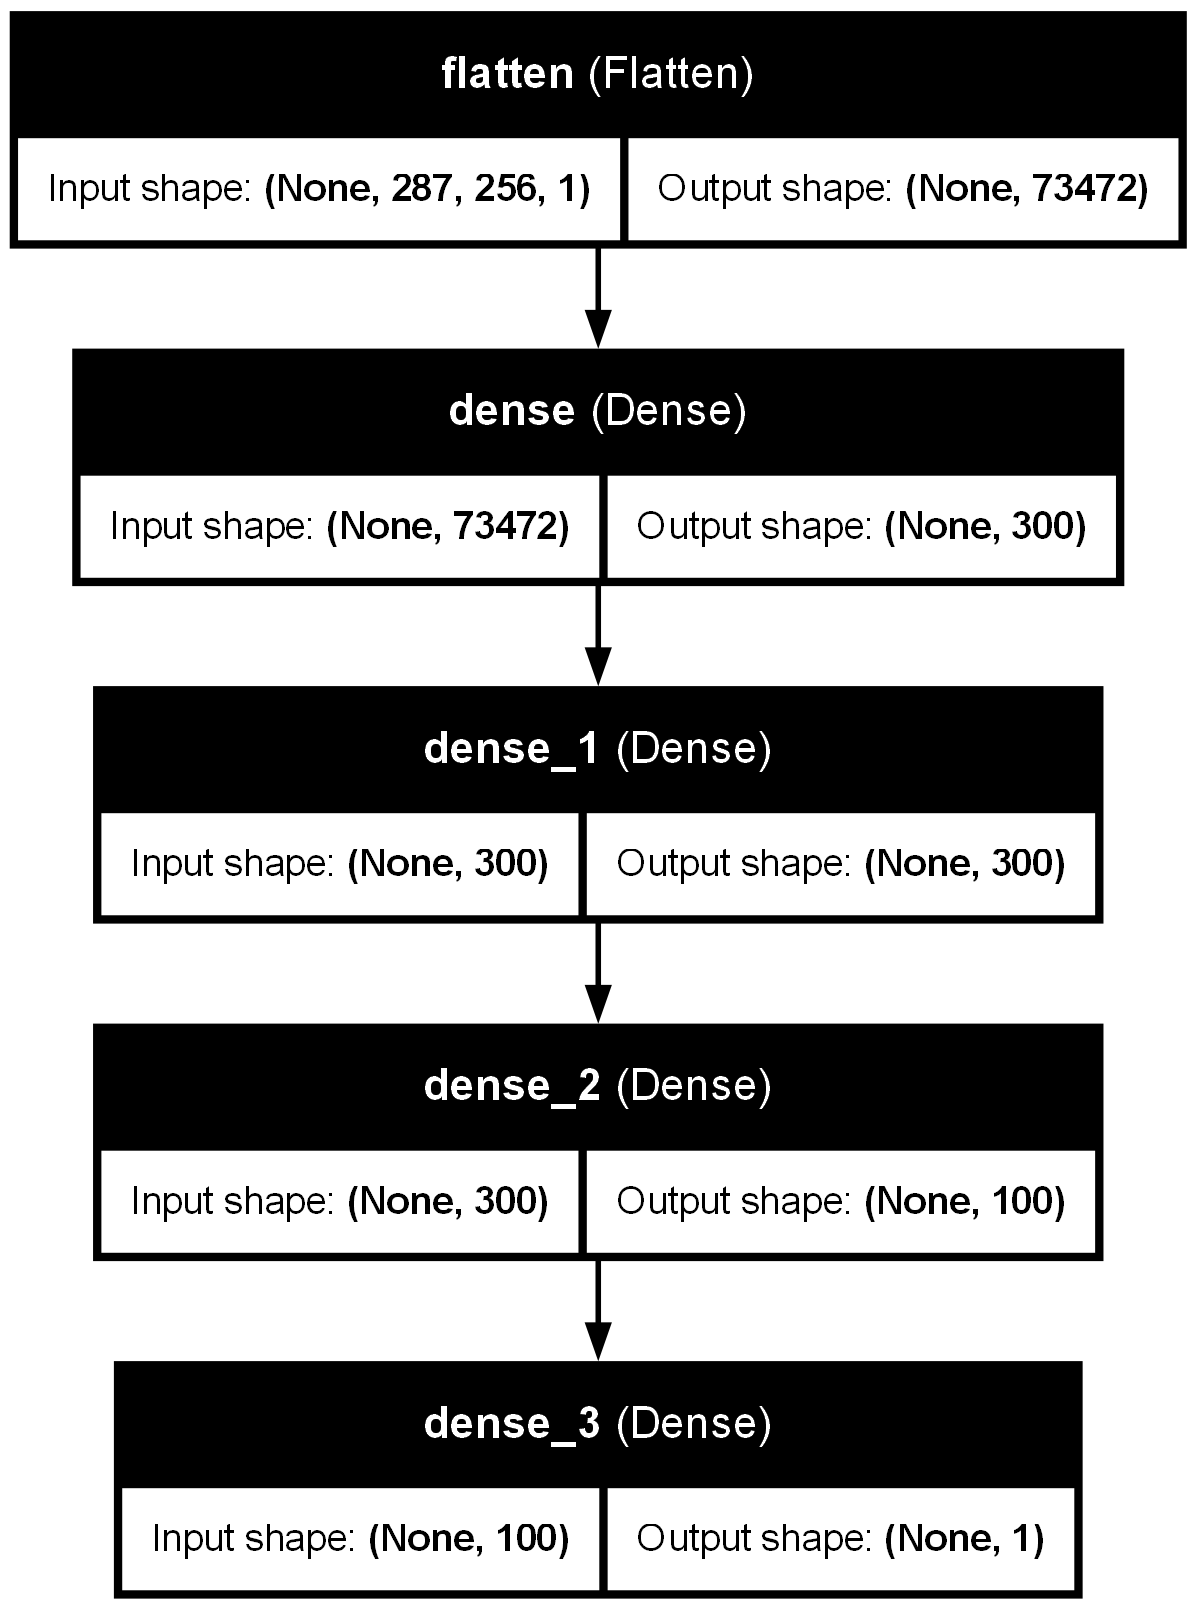

In [ ]:
from tensorflow.keras.utils import plot_model
import pydot

# Create the model
model = create_model()

# Now plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
model = KerasClassifier(build_fn=create_model, verbose=1)

param_grid = {
    'batch_size': [16, 32],
    'epochs': [5, 10, 15],
    'model__learning_rate': [0.005, 0.01, 0.2]
}

#Set up the grid search
grid = GridSearchCV(estimator = model, n_jobs = 1, param_grid = param_grid)

#Fit model
grid_result = grid.fit(x_train, y_train, validation_data=(x_val, y_val))

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7725 - loss: 0.5178 - val_accuracy: 0.8125 - val_loss: 0.5358
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8692 - loss: 0.3018 - val_accuracy: 0.7500 - val_loss: 0.3962
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8970 - loss: 0.2360 - val_accuracy: 0.9375 - val_loss: 0.2743
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.9141 - loss: 0.2020 - val_accuracy: 0.6875 - val_loss: 0.6549
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9290 - loss: 0.1803 - val_accuracy: 0.7500 - val_loss: 0.5284
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7140 - loss: 0.5843 - val_accuracy: 0.6875 - val_loss: 0.6930
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8836 - loss: 0.2898 - val_accuracy: 0.6250 - val_loss: 0.8710
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9074 - loss: 0.2384 - val_accuracy: 0.8125 - val_loss: 0.5943
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9297 - loss: 0.1773 - val_accuracy: 0.9375 - val_loss: 0.2712
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9384 - loss: 0.1587 - val_accuracy: 0.8125 - val_loss: 0.4792
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7379 - loss: 0.5359 - val_accuracy: 0.5000 - val_loss: 1.4994
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8656 - loss: 0.3210 - val_accuracy: 0.6875 - val_loss: 0.6953
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9178 - loss: 0.2135 - val_accuracy: 0.9375 - val_loss: 0.3204
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9183 - loss: 0.1965 - val_accuracy: 0.8125 - val_loss: 0.4467
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9266 - loss: 0.1838 - val_accuracy: 0.8125 - val_loss: 0.5307
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7325 - loss: 0.5224 - val_accuracy: 0.7500 - val_loss: 0.4980
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8668 - loss: 0.3124 - val_accuracy: 0.8125 - val_loss: 0.5364
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9110 - loss: 0.2254 - val_accuracy: 0.8125 - val_loss: 0.4513
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9196 - loss: 0.2045 - val_accuracy: 0.9375 - val_loss: 0.2635
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9361 - loss: 0.1686 - val_accuracy: 0.8750 - val_loss: 0.3770
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7487 - loss: 0.5460 - val_accuracy: 0.6250 - val_loss: 1.1213
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8836 - loss: 0.2756 - val_accuracy: 0.6250 - val_loss: 1.0337
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9035 - loss: 0.2352 - val_accuracy: 0.5625 - val_loss: 1.4714
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9193 - loss: 0.2017 - val_accuracy: 0.9375 - val_loss: 0.2735
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9299 - loss: 0.1694 - val_accuracy: 0.9375 - val_loss: 0.2589
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7099 - loss: 0.6377 - val_accuracy: 0.6250 - val_loss: 0.7576
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8496 - loss: 0.3311 - val_accuracy: 0.6875 - val_loss: 0.7541
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9073 - loss: 0.2304 - val_accuracy: 0.7500 - val_loss: 0.7891
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9074 - loss: 0.2235 - val_accuracy: 0.7500 - val_loss: 0.5707
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9315 - loss: 0.1729 - val_accuracy: 0.9375 - val_loss: 0.2730
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7237 - loss: 0.5938 - val_accuracy: 0.5000 - val_loss: 1.6332
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8653 - loss: 0.3404 - val_accuracy: 0.8125 - val_loss: 0.4561
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9080 - loss: 0.2269 - val_accuracy: 0.8125 - val_loss: 0.5122
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9243 - loss: 0.1817 - val_accuracy: 0.9375 - val_loss: 0.3208
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9374 - loss: 0.1582 - val_accuracy: 0.5625 - val_loss: 1.5809
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7258 - loss: 0.5784 - val_accuracy: 0.7500 - val_loss: 0.6114
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8643 - loss: 0.3319 - val_accuracy: 0.6875 - val_loss: 0.7363
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8944 - loss: 0.2541 - val_accuracy: 0.6875 - val_loss: 0.5602
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9158 - loss: 0.2017 - val_accuracy: 0.6875 - val_loss: 0.6177
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9317 - loss: 0.1843 - val_accuracy: 0.6875 - val_loss: 0.5861
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7282 - loss: 0.5788 - val_accuracy: 0.8125 - val_loss: 0.5437
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8718 - loss: 0.3103 - val_accuracy: 0.6250 - val_loss: 1.1393
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8983 - loss: 0.2469 - val_accuracy: 0.7500 - val_loss: 0.5679
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9167 - loss: 0.2123 - val_accuracy: 0.8125 - val_loss: 0.5242
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9281 - loss: 0.1836 - val_accuracy: 0.9375 - val_loss: 0.2538
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7261 - loss: 0.5843 - val_accuracy: 0.5625 - val_loss: 0.9636
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8619 - loss: 0.3297 - val_accuracy: 0.7500 - val_loss: 0.6760
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8984 - loss: 0.2416 - val_accuracy: 0.6875 - val_loss: 0.7282
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9159 - loss: 0.2167 - val_accuracy: 0.8750 - val_loss: 0.3460
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9282 - loss: 0.1845 - val_accuracy: 0.8125 - val_loss: 0.4861
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.3004 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2545 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2573 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2608 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2507 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.2928 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2495 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2501 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2561 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2520 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7003 - loss: 10822.1367 - val_accuracy: 0.5000 - val_loss: 0.8247
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7499 - loss: 0.5632 - val_accuracy: 0.5000 - val_loss: 0.8321
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7397 - loss: 0.5743 - val_accuracy: 0.5000 - val_loss: 0.8357
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7463 - loss: 0.5676 - val_accuracy: 0.5000 - val_loss: 0.8257
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7364 - loss: 0.5776 - val_accuracy: 0.5000 - val_loss: 0.8251
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2881 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2632 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2562 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2516 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2571 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.3006 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2569 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2633 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2507 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2601 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7379 - loss: 0.5275 - val_accuracy: 0.5000 - val_loss: 1.0788
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8709 - loss: 0.2860 - val_accuracy: 0.8750 - val_loss: 0.3850
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9147 - loss: 0.2135 - val_accuracy: 0.8750 - val_loss: 0.3682
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9239 - loss: 0.1831 - val_accuracy: 0.6875 - val_loss: 0.6237
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9404 - loss: 0.1478 - val_accuracy: 0.9375 - val_loss: 0.2365
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9369 - loss: 0.1553 - val_accuracy: 0.8125 - val_loss: 0.4585
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9489 - loss: 0.1336 - val_accuracy: 0.9375 - val_loss: 0.2112
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9454 - loss: 0.1350 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.7415 - loss: 0.5160 - val_accuracy: 0.8125 - val_loss: 0.4734
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8764 - loss: 0.3006 - val_accuracy: 0.8750 - val_loss: 0.3062
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9156 - loss: 0.2135 - val_accuracy: 0.9375 - val_loss: 0.2939
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9230 - loss: 0.1905 - val_accuracy: 0.8125 - val_loss: 0.6039
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9394 - loss: 0.1576 - val_accuracy: 0.6875 - val_loss: 0.7752
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9396 - loss: 0.1538 - val_accuracy: 0.8125 - val_loss: 0.5340
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9395 - loss: 0.1445 - val_accuracy: 0.9375 - val_loss: 0.1909
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9309 - loss: 0.1869 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7675 - loss: 0.5333 - val_accuracy: 0.6875 - val_loss: 0.8051
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8706 - loss: 0.3025 - val_accuracy: 0.8125 - val_loss: 0.3849
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9049 - loss: 0.2304 - val_accuracy: 0.8750 - val_loss: 0.3306
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9126 - loss: 0.1999 - val_accuracy: 0.8125 - val_loss: 0.3567
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9288 - loss: 0.1851 - val_accuracy: 0.8125 - val_loss: 0.4733
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9256 - loss: 0.1890 - val_accuracy: 0.9375 - val_loss: 0.2006
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9424 - loss: 0.1466 - val_accuracy: 0.8125 - val_loss: 0.5258
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9452 - loss: 0.1430 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7327 - loss: 0.5300 - val_accuracy: 0.8125 - val_loss: 0.4977
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8717 - loss: 0.3098 - val_accuracy: 0.6875 - val_loss: 0.7356
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9070 - loss: 0.2327 - val_accuracy: 0.9375 - val_loss: 0.3216
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9084 - loss: 0.2082 - val_accuracy: 0.8750 - val_loss: 0.2558
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9341 - loss: 0.1798 - val_accuracy: 0.9375 - val_loss: 0.3323
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9378 - loss: 0.1540 - val_accuracy: 0.8750 - val_loss: 0.3948
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9427 - loss: 0.1607 - val_accuracy: 0.9375 - val_loss: 0.2052
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9444 - loss: 0.1460 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7348 - loss: 0.5503 - val_accuracy: 0.6250 - val_loss: 0.9563
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8868 - loss: 0.2829 - val_accuracy: 0.7500 - val_loss: 0.4432
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9067 - loss: 0.2317 - val_accuracy: 0.8750 - val_loss: 0.3501
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9271 - loss: 0.1881 - val_accuracy: 0.7500 - val_loss: 0.6779
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9209 - loss: 0.1857 - val_accuracy: 0.8750 - val_loss: 0.3782
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9375 - loss: 0.1536 - val_accuracy: 0.8125 - val_loss: 0.4579
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9499 - loss: 0.1304 - val_accuracy: 0.8125 - val_loss: 0.4658
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9465 - loss: 0.1407 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7637 - loss: 0.5408 - val_accuracy: 0.7500 - val_loss: 0.4826
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8712 - loss: 0.3160 - val_accuracy: 0.8125 - val_loss: 0.5448
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9004 - loss: 0.2440 - val_accuracy: 0.6875 - val_loss: 0.6831
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9272 - loss: 0.1866 - val_accuracy: 0.8125 - val_loss: 0.5340
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9310 - loss: 0.1751 - val_accuracy: 0.7500 - val_loss: 0.6571
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9439 - loss: 0.1468 - val_accuracy: 0.9375 - val_loss: 0.2722
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9330 - loss: 0.1581 - val_accuracy: 0.8125 - val_loss: 0.3618
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9372 - loss: 0.1583 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7235 - loss: 0.5962 - val_accuracy: 0.6875 - val_loss: 0.6169
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8663 - loss: 0.3110 - val_accuracy: 0.8125 - val_loss: 0.4364
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9054 - loss: 0.2475 - val_accuracy: 0.8750 - val_loss: 0.3380
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9259 - loss: 0.1858 - val_accuracy: 0.5625 - val_loss: 1.4497
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9222 - loss: 0.1848 - val_accuracy: 0.6250 - val_loss: 0.7943
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9494 - loss: 0.1388 - val_accuracy: 0.9375 - val_loss: 0.3077
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9465 - loss: 0.1471 - val_accuracy: 0.8750 - val_loss: 0.2296
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9454 - loss: 0.1390 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.6961 - loss: 0.6051 - val_accuracy: 0.6250 - val_loss: 0.9588
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.8649 - loss: 0.3211 - val_accuracy: 0.7500 - val_loss: 0.5844
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9049 - loss: 0.2559 - val_accuracy: 0.8125 - val_loss: 0.4975
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9163 - loss: 0.2035 - val_accuracy: 0.8125 - val_loss: 0.2874
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9215 - loss: 0.1952 - val_accuracy: 0.8750 - val_loss: 0.3277
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9418 - loss: 0.1482 - val_accuracy: 0.7500 - val_loss: 0.5137
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9403 - loss: 0.1550 - val_accuracy: 0.9375 - val_loss: 0.2370
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9344 - loss: 0.1570 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7282 - loss: 0.7719 - val_accuracy: 0.6250 - val_loss: 0.9126
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8489 - loss: 0.3381 - val_accuracy: 0.5625 - val_loss: 1.4524
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9096 - loss: 0.2232 - val_accuracy: 0.8750 - val_loss: 0.3863
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9193 - loss: 0.1956 - val_accuracy: 0.8750 - val_loss: 0.3061
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9268 - loss: 0.1819 - val_accuracy: 0.8750 - val_loss: 0.3901
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9338 - loss: 0.1647 - val_accuracy: 0.9375 - val_loss: 0.2948
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9256 - loss: 0.1796 - val_accuracy: 0.7500 - val_loss: 0.6000
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9422 - loss: 0.1394 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7495 - loss: 0.5664 - val_accuracy: 0.6250 - val_loss: 0.8957
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8649 - loss: 0.3298 - val_accuracy: 0.6875 - val_loss: 0.7469
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9008 - loss: 0.2415 - val_accuracy: 0.8750 - val_loss: 0.3206
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9225 - loss: 0.2031 - val_accuracy: 0.7500 - val_loss: 0.6801
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9293 - loss: 0.1820 - val_accuracy: 0.8750 - val_loss: 0.3504
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9419 - loss: 0.1539 - val_accuracy: 0.8750 - val_loss: 0.4284
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9381 - loss: 0.1503 - val_accuracy: 0.8125 - val_loss: 0.5036
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9443 - loss: 0.1381 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.2999 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2494 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2760 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2682 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2498 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2570 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2505 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2542 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/10
261/2

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7066 - loss: 618009665428851001393152.0000 - val_accuracy: 0.5000 - val_loss: 0.8188
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7401 - loss: 0.5738 - val_accuracy: 0.5000 - val_loss: 0.8396
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7478 - loss: 0.5653 - val_accuracy: 0.5000 - val_loss: 0.8247
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7462 - loss: 0.5673 - val_accuracy: 0.5000 - val_loss: 0.8287
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7426 - loss: 0.5710 - val_accuracy: 0.5000 - val_loss: 0.8454
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7396 - loss: 0.5748 - val_accuracy: 0.5000 - val_loss: 0.8096
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7446 - loss: 0.5695 - val_accuracy: 0.5000 - val_loss: 0.8326
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.7597 - 

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.3017 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2548 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2566 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2559 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2602 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2603 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2563 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2643 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/10
261/2

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.3032 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2641 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2678 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2642 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2621 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2601 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2529 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2521 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/10
261/2

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.3072 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2538 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2592 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2576 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2579 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2514 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2581 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/10
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2457 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/10
261/2

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7567 - loss: 0.5451 - val_accuracy: 0.8125 - val_loss: 0.5447
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8902 - loss: 0.2784 - val_accuracy: 0.6875 - val_loss: 0.8749
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9098 - loss: 0.2301 - val_accuracy: 0.8750 - val_loss: 0.3306
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9260 - loss: 0.1848 - val_accuracy: 0.6250 - val_loss: 1.1822
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9304 - loss: 0.1777 - val_accuracy: 0.7500 - val_loss: 0.2917
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9384 - loss: 0.1601 - val_accuracy: 0.7500 - val_loss: 0.6341
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9350 - loss: 0.1615 - val_accuracy: 0.6250 - val_loss: 0.8099
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9466 - loss: 0.1463 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7512 - loss: 0.5396 - val_accuracy: 0.6250 - val_loss: 0.7223
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8880 - loss: 0.2763 - val_accuracy: 0.6250 - val_loss: 0.9310
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9043 - loss: 0.2441 - val_accuracy: 0.5625 - val_loss: 1.4110
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9240 - loss: 0.1916 - val_accuracy: 0.6875 - val_loss: 0.6682
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9288 - loss: 0.1800 - val_accuracy: 0.8125 - val_loss: 0.3527
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9444 - loss: 0.1525 - val_accuracy: 0.8125 - val_loss: 0.3496
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9467 - loss: 0.1365 - val_accuracy: 0.6250 - val_loss: 1.0175
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9420 - loss: 0.1411 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.7349 - loss: 0.5331 - val_accuracy: 0.8125 - val_loss: 0.5180
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8729 - loss: 0.2985 - val_accuracy: 0.8750 - val_loss: 0.3521
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9065 - loss: 0.2359 - val_accuracy: 0.8750 - val_loss: 0.3398
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9273 - loss: 0.1883 - val_accuracy: 0.6875 - val_loss: 0.8307
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9226 - loss: 0.1885 - val_accuracy: 0.8125 - val_loss: 0.4288
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9322 - loss: 0.1736 - val_accuracy: 0.9375 - val_loss: 0.2288
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9393 - loss: 0.1524 - val_accuracy: 0.8125 - val_loss: 0.4015
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9381 - loss: 0.1563 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7553 - loss: 0.5339 - val_accuracy: 0.6250 - val_loss: 0.8684
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8752 - loss: 0.3040 - val_accuracy: 0.8750 - val_loss: 0.3657
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9116 - loss: 0.2256 - val_accuracy: 0.8750 - val_loss: 0.3698
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9269 - loss: 0.1870 - val_accuracy: 0.8750 - val_loss: 0.3438
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9375 - loss: 0.1617 - val_accuracy: 0.9375 - val_loss: 0.2531
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9420 - loss: 0.1530 - val_accuracy: 0.9375 - val_loss: 0.2782
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9420 - loss: 0.1471 - val_accuracy: 0.7500 - val_loss: 0.6213
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9453 - loss: 0.1414 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7097 - loss: 0.5625 - val_accuracy: 0.6875 - val_loss: 0.6958
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8842 - loss: 0.2843 - val_accuracy: 0.6250 - val_loss: 0.8677
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8935 - loss: 0.2444 - val_accuracy: 0.6875 - val_loss: 0.7600
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9223 - loss: 0.1854 - val_accuracy: 0.8750 - val_loss: 0.3154
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9266 - loss: 0.1786 - val_accuracy: 0.9375 - val_loss: 0.2372
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9371 - loss: 0.1668 - val_accuracy: 0.8125 - val_loss: 0.4316
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9442 - loss: 0.1453 - val_accuracy: 0.7500 - val_loss: 0.7967
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9399 - loss: 0.1500 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7300 - loss: 0.6355 - val_accuracy: 0.7500 - val_loss: 0.4754
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8601 - loss: 0.3182 - val_accuracy: 0.6875 - val_loss: 0.7009
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9147 - loss: 0.2209 - val_accuracy: 0.6250 - val_loss: 0.8915
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9243 - loss: 0.1867 - val_accuracy: 0.9375 - val_loss: 0.2724
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9188 - loss: 0.1958 - val_accuracy: 0.6875 - val_loss: 0.6779
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9426 - loss: 0.1515 - val_accuracy: 0.8125 - val_loss: 0.3864
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9581 - loss: 0.1227 - val_accuracy: 0.9375 - val_loss: 0.3502
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9443 - loss: 0.1364 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7334 - loss: 0.6100 - val_accuracy: 0.7500 - val_loss: 0.4700
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8751 - loss: 0.2882 - val_accuracy: 0.8125 - val_loss: 0.4208
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8962 - loss: 0.2370 - val_accuracy: 0.5625 - val_loss: 0.7634
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8981 - loss: 0.2671 - val_accuracy: 0.9375 - val_loss: 0.2697
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9343 - loss: 0.1616 - val_accuracy: 0.8750 - val_loss: 0.3915
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9351 - loss: 0.1703 - val_accuracy: 0.8125 - val_loss: 0.5498
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9430 - loss: 0.1514 - val_accuracy: 0.6875 - val_loss: 0.6444
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9418 - loss: 0.1423 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7092 - loss: 0.5998 - val_accuracy: 0.7500 - val_loss: 0.5033
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8491 - loss: 0.3481 - val_accuracy: 0.5000 - val_loss: 2.4869
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8959 - loss: 0.2631 - val_accuracy: 0.8125 - val_loss: 0.4371
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9132 - loss: 0.2141 - val_accuracy: 0.8125 - val_loss: 0.4342
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9132 - loss: 0.2074 - val_accuracy: 0.8125 - val_loss: 0.3625
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9284 - loss: 0.1687 - val_accuracy: 0.8125 - val_loss: 0.3672
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9348 - loss: 0.1541 - val_accuracy: 0.8125 - val_loss: 0.4485
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9304 - loss: 0.1547 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7173 - loss: 0.5982 - val_accuracy: 0.6250 - val_loss: 0.8554
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.8671 - loss: 0.3191 - val_accuracy: 0.7500 - val_loss: 0.6343
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9068 - loss: 0.2379 - val_accuracy: 0.8125 - val_loss: 0.4629
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9082 - loss: 0.2262 - val_accuracy: 0.7500 - val_loss: 0.3669
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9204 - loss: 0.1986 - val_accuracy: 0.9375 - val_loss: 0.2866
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9293 - loss: 0.1787 - val_accuracy: 0.7500 - val_loss: 0.5433
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9362 - loss: 0.1624 - val_accuracy: 0.8125 - val_loss: 0.2492
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9320 - loss: 0.1834 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.7290 - loss: 0.5845 - val_accuracy: 0.6250 - val_loss: 0.7092
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8440 - loss: 0.3429 - val_accuracy: 0.6875 - val_loss: 0.6344
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.8978 - loss: 0.2249 - val_accuracy: 0.8750 - val_loss: 0.4037
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9225 - loss: 0.2061 - val_accuracy: 0.8125 - val_loss: 0.4731
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9229 - loss: 0.2100 - val_accuracy: 0.7500 - val_loss: 0.6925
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9257 - loss: 0.1844 - val_accuracy: 0.9375 - val_loss: 0.2714
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9393 - loss: 0.1631 - val_accuracy: 0.9375 - val_loss: 0.2173
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.9281 - loss: 0.1643 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.2929 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2520 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2501 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2604 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2555 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2506 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2605 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - accuracy: 0.2621 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/15
261/2

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.2903 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2582 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2561 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2528 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2557 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2499 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2678 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2494 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/15
261/2

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.3075 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2673 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2625 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2587 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2596 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2659 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.2569 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2418 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/15
261/2

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.2945 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2605 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.2488 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.2600 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2496 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.2565 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.2601 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2531 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/15
261/2

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.3067 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.2603 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2506 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2488 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.2533 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.2547 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.2572 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.2770 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/15
261/2

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7296 - loss: 0.5385 - val_accuracy: 0.6875 - val_loss: 0.5997
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8644 - loss: 0.3302 - val_accuracy: 0.8750 - val_loss: 0.4470
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8914 - loss: 0.2717 - val_accuracy: 0.5000 - val_loss: 2.0159
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9083 - loss: 0.2265 - val_accuracy: 0.6875 - val_loss: 0.8308
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9316 - loss: 0.1678 - val_accuracy: 0.8750 - val_loss: 0.3092
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7581 - loss: 0.5526 - val_accuracy: 0.5000 - val_loss: 1.1891
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8443 - loss: 0.3552 - val_accuracy: 0.8125 - val_loss: 0.4719
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8948 - loss: 0.2678 - val_accuracy: 0.7500 - val_loss: 0.4304
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9106 - loss: 0.2261 - val_accuracy: 0.8750 - val_loss: 0.3323
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9273 - loss: 0.1823 - val_accuracy: 0.5000 - val_loss: 1.0119
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7587 - loss: 0.5288 - val_accuracy: 0.6250 - val_loss: 0.6581
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8440 - loss: 0.3766 - val_accuracy: 0.6250 - val_loss: 0.8947
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8903 - loss: 0.2748 - val_accuracy: 0.6250 - val_loss: 1.1806
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9070 - loss: 0.2383 - val_accuracy: 0.8750 - val_loss: 0.3572
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9147 - loss: 0.2208 - val_accuracy: 0.6250 - val_loss: 0.8948
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7356 - loss: 0.5649 - val_accuracy: 0.5000 - val_loss: 1.1071
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8233 - loss: 0.4181 - val_accuracy: 0.6250 - val_loss: 0.9606
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8730 - loss: 0.3119 - val_accuracy: 0.6250 - val_loss: 0.9249
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8789 - loss: 0.2854 - val_accuracy: 0.8750 - val_loss: 0.3349
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9142 - loss: 0.2072 - val_accuracy: 0.8125 - val_loss: 0.5141
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7295 - loss: 0.5492 - val_accuracy: 0.8125 - val_loss: 0.5536
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8136 - loss: 0.4110 - val_accuracy: 0.8125 - val_loss: 0.4491
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8878 - loss: 0.2844 - val_accuracy: 0.8125 - val_loss: 0.5067
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9108 - loss: 0.2218 - val_accuracy: 0.9375 - val_loss: 0.3152
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9272 - loss: 0.1882 - val_accuracy: 0.8750 - val_loss: 0.3584
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6997 - loss: 0.6771 - val_accuracy: 0.7500 - val_loss: 0.5672
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8271 - loss: 0.4107 - val_accuracy: 0.6250 - val_loss: 0.7829
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8688 - loss: 0.3181 - val_accuracy: 0.5000 - val_loss: 1.3025
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8924 - loss: 0.2552 - val_accuracy: 0.6250 - val_loss: 1.0868
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9092 - loss: 0.2279 - val_accuracy: 0.5625 - val_loss: 1.2978
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6956 - loss: 0.6717 - val_accuracy: 0.5000 - val_loss: 0.8728
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8101 - loss: 0.4258 - val_accuracy: 0.6875 - val_loss: 0.6374
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8778 - loss: 0.3131 - val_accuracy: 0.5000 - val_loss: 1.4649
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8706 - loss: 0.3095 - val_accuracy: 0.6875 - val_loss: 0.7183
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9191 - loss: 0.2035 - val_accuracy: 0.8125 - val_loss: 0.4495
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7554 - loss: 0.5927 - val_accuracy: 0.6250 - val_loss: 0.6465
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8358 - loss: 0.3961 - val_accuracy: 0.6875 - val_loss: 0.8163
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8616 - loss: 0.3247 - val_accuracy: 0.6875 - val_loss: 0.5884
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8914 - loss: 0.2551 - val_accuracy: 0.6250 - val_loss: 0.9770
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8983 - loss: 0.2497 - val_accuracy: 0.6875 - val_loss: 0.8061
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6753 - loss: 0.7213 - val_accuracy: 0.7500 - val_loss: 0.5558
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8045 - loss: 0.4262 - val_accuracy: 0.6250 - val_loss: 1.1230
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8590 - loss: 0.3390 - val_accuracy: 0.6875 - val_loss: 0.7979
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8809 - loss: 0.2871 - val_accuracy: 0.8750 - val_loss: 0.4136
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9073 - loss: 0.2327 - val_accuracy: 0.8125 - val_loss: 0.5047
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6808 - loss: 0.6515 - val_accuracy: 0.6250 - val_loss: 0.6347
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7969 - loss: 0.4432 - val_accuracy: 0.6250 - val_loss: 0.8372
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8681 - loss: 0.3100 - val_accuracy: 0.8125 - val_loss: 0.4543
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9183 - loss: 0.2081 - val_accuracy: 0.8125 - val_loss: 0.4133
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9149 - loss: 0.2115 - val_accuracy: 0.6875 - val_loss: 0.8865
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6403 - loss: nan - val_accuracy: 0.5000 - val_loss: 0.8340
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7448 - loss: 0.5684 - val_accuracy: 0.5000 - val_loss: 0.8220
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7502 - loss: 0.5626 - val_accuracy: 0.5000 - val_loss: 0.8376
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7381 - loss: 0.5755 - val_accuracy: 0.5000 - val_loss: 0.8546
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7438 - loss: 0.5696 - val_accuracy: 0.5000 - val_loss: 0.8259
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.3171 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2526 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2635 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2672 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2653 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.3301 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2639 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2595 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2644 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2692 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6976 - loss: 99552484917248.0000 - val_accuracy: 0.5000 - val_loss: 0.8265
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7488 - loss: 0.5640 - val_accuracy: 0.5000 - val_loss: 0.8160
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7363 - loss: 0.5770 - val_accuracy: 0.5000 - val_loss: 0.8191
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7338 - loss: 0.5797 - val_accuracy: 0.5000 - val_loss: 0.8296
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7444 - loss: 0.5688 - val_accuracy: 0.5000 - val_loss: 0.8178
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.3155 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2548 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2554 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2608 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/5
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2562 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7557 - loss: 0.5421 - val_accuracy: 0.6250 - val_loss: 0.6924
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8419 - loss: 0.3605 - val_accuracy: 0.6875 - val_loss: 0.7182
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8924 - loss: 0.2719 - val_accuracy: 0.8125 - val_loss: 0.3760
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8979 - loss: 0.2487 - val_accuracy: 0.6875 - val_loss: 0.6474
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9258 - loss: 0.1767 - val_accuracy: 0.9375 - val_loss: 0.3056
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9288 - loss: 0.1772 - val_accuracy: 0.6875 - val_loss: 0.8251
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9368 - loss: 0.1554 - val_accuracy: 0.6875 - val_loss: 0.8332
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9410 - loss: 0.1550 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7411 - loss: 0.5763 - val_accuracy: 0.5000 - val_loss: 2.4262
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8338 - loss: 0.4015 - val_accuracy: 0.6250 - val_loss: 0.9551
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8850 - loss: 0.2841 - val_accuracy: 0.7500 - val_loss: 0.4141
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9052 - loss: 0.2371 - val_accuracy: 0.6875 - val_loss: 0.8227
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9202 - loss: 0.2079 - val_accuracy: 0.6875 - val_loss: 0.7499
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9346 - loss: 0.1718 - val_accuracy: 0.8750 - val_loss: 0.3261
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9314 - loss: 0.1862 - val_accuracy: 0.8125 - val_loss: 0.3965
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9470 - loss: 0.1391 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7468 - loss: 0.5424 - val_accuracy: 0.5625 - val_loss: 0.9467
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8312 - loss: 0.3776 - val_accuracy: 0.5625 - val_loss: 1.3187
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8765 - loss: 0.2970 - val_accuracy: 0.6250 - val_loss: 0.7801
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8989 - loss: 0.2313 - val_accuracy: 0.7500 - val_loss: 0.6365
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8963 - loss: 0.2453 - val_accuracy: 0.5000 - val_loss: 1.3075
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9004 - loss: 0.2543 - val_accuracy: 0.6875 - val_loss: 0.6952
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9288 - loss: 0.1678 - val_accuracy: 0.8750 - val_loss: 0.2621
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9337 - loss: 0.1796 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7503 - loss: 0.5567 - val_accuracy: 0.5000 - val_loss: 1.0144
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8120 - loss: 0.3986 - val_accuracy: 0.7500 - val_loss: 0.5819
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8890 - loss: 0.2680 - val_accuracy: 0.8125 - val_loss: 0.6072
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8852 - loss: 0.2545 - val_accuracy: 0.8750 - val_loss: 0.3331
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9192 - loss: 0.2052 - val_accuracy: 0.8750 - val_loss: 0.2767
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9146 - loss: 0.2213 - val_accuracy: 0.7500 - val_loss: 0.7111
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9261 - loss: 0.1886 - val_accuracy: 0.8125 - val_loss: 0.4991
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9337 - loss: 0.1669 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7509 - loss: 0.5588 - val_accuracy: 0.7500 - val_loss: 0.5368
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8446 - loss: 0.3675 - val_accuracy: 0.6875 - val_loss: 0.6176
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8542 - loss: 0.3416 - val_accuracy: 0.6875 - val_loss: 0.6639
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8885 - loss: 0.2845 - val_accuracy: 0.8750 - val_loss: 0.3418
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9123 - loss: 0.2208 - val_accuracy: 0.8750 - val_loss: 0.3676
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9284 - loss: 0.1766 - val_accuracy: 0.9375 - val_loss: 0.2824
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9339 - loss: 0.1820 - val_accuracy: 0.8125 - val_loss: 0.5184
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9396 - loss: 0.1554 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6983 - loss: 0.6083 - val_accuracy: 0.5625 - val_loss: 0.9765
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8043 - loss: 0.4333 - val_accuracy: 0.6250 - val_loss: 0.9076
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8682 - loss: 0.3211 - val_accuracy: 0.6875 - val_loss: 0.9467
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8833 - loss: 0.2856 - val_accuracy: 0.7500 - val_loss: 0.5730
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9243 - loss: 0.1976 - val_accuracy: 0.8750 - val_loss: 0.3881
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9355 - loss: 0.1706 - val_accuracy: 0.8750 - val_loss: 0.3362
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9226 - loss: 0.1877 - val_accuracy: 0.6875 - val_loss: 0.8448
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9386 - loss: 0.1620 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7540 - loss: 0.6201 - val_accuracy: 0.5000 - val_loss: 1.2172
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8300 - loss: 0.4052 - val_accuracy: 0.6250 - val_loss: 1.0955
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8462 - loss: 0.3349 - val_accuracy: 0.6875 - val_loss: 0.6311
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9104 - loss: 0.2354 - val_accuracy: 0.6875 - val_loss: 0.8472
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9219 - loss: 0.1989 - val_accuracy: 0.9375 - val_loss: 0.2954
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9302 - loss: 0.1891 - val_accuracy: 0.9375 - val_loss: 0.2574
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9374 - loss: 0.1615 - val_accuracy: 0.9375 - val_loss: 0.2916
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9392 - loss: 0.1644 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6920 - loss: 0.6410 - val_accuracy: 0.6875 - val_loss: 0.6047
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8341 - loss: 0.3948 - val_accuracy: 0.6875 - val_loss: 0.7177
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8408 - loss: 0.3525 - val_accuracy: 0.6875 - val_loss: 0.5621
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8939 - loss: 0.2580 - val_accuracy: 0.8125 - val_loss: 0.3409
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9126 - loss: 0.2345 - val_accuracy: 0.5000 - val_loss: 2.2895
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9219 - loss: 0.2356 - val_accuracy: 0.7500 - val_loss: 0.5728
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9208 - loss: 0.1856 - val_accuracy: 0.8750 - val_loss: 0.3210
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9326 - loss: 0.1732 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7050 - loss: 0.6603 - val_accuracy: 0.5625 - val_loss: 0.9144
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8052 - loss: 0.4102 - val_accuracy: 0.7500 - val_loss: 0.6037
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8745 - loss: 0.2908 - val_accuracy: 0.6250 - val_loss: 0.8367
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8893 - loss: 0.2665 - val_accuracy: 0.8750 - val_loss: 0.3389
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9153 - loss: 0.2112 - val_accuracy: 0.8750 - val_loss: 0.3423
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9138 - loss: 0.2174 - val_accuracy: 0.9375 - val_loss: 0.2697
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9300 - loss: 0.1746 - val_accuracy: 0.8125 - val_loss: 0.3927
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9349 - loss: 0.1750 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7058 - loss: 0.6064 - val_accuracy: 0.5000 - val_loss: 0.8995
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8090 - loss: 0.3996 - val_accuracy: 0.6250 - val_loss: 1.0724
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8724 - loss: 0.3093 - val_accuracy: 0.8125 - val_loss: 0.3908
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9064 - loss: 0.2407 - val_accuracy: 0.6875 - val_loss: 0.7334
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9068 - loss: 0.2269 - val_accuracy: 0.8750 - val_loss: 0.3122
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9207 - loss: 0.2017 - val_accuracy: 0.8750 - val_loss: 0.3752
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9229 - loss: 0.2030 - val_accuracy: 0.8750 - val_loss: 0.2517
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9321 - loss: 0.1701 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.3334 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2637 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2475 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2651 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2564 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2536 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2551 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2606 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/10
131/1

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.3252 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2519 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2641 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2529 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2630 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2595 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2689 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.2559 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/10
131/1

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6744 - loss: 47902292919685484994922962485248.0000 - val_accuracy: 0.5000 - val_loss: 0.8126
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7466 - loss: 0.5666 - val_accuracy: 0.5000 - val_loss: 0.8200
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7404 - loss: 0.5731 - val_accuracy: 0.5000 - val_loss: 0.8437
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.7496 - loss: 0.5630 - val_accuracy: 0.5000 - val_loss: 0.8031
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7500 - loss: 0.5635 - val_accuracy: 0.5000 - val_loss: 0.8279
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7542 - loss: 0.5578 - val_accuracy: 0.5000 - val_loss: 0.8309
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7456 - loss: 0.5675 - val_accuracy: 0.5000 - val_loss: 0.8155
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.6941 - loss: 3704263892282831273984.0000 - val_accuracy: 0.5000 - val_loss: 0.8196
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7371 - loss: 0.5765 - val_accuracy: 0.5000 - val_loss: 0.8394
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7508 - loss: 0.5618 - val_accuracy: 0.5000 - val_loss: 0.8238
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7473 - loss: 0.5658 - val_accuracy: 0.5000 - val_loss: 0.8254
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7449 - loss: 0.5681 - val_accuracy: 0.5000 - val_loss: 0.8189
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7446 - loss: 0.5686 - val_accuracy: 0.5000 - val_loss: 0.8222
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7410 - loss: 0.5723 - val_accuracy: 0.5000 - val_loss: 0.8093
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7338 - lo

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6704 - loss: inf - val_accuracy: 0.5000 - val_loss: 0.8375
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7354 - loss: 0.5784 - val_accuracy: 0.5000 - val_loss: 0.8505
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7470 - loss: 0.5662 - val_accuracy: 0.5000 - val_loss: 0.8249
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7565 - loss: 0.5558 - val_accuracy: 0.5000 - val_loss: 0.8146
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7432 - loss: 0.5705 - val_accuracy: 0.5000 - val_loss: 0.8251
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7380 - loss: 0.5754 - val_accuracy: 0.5000 - val_loss: 0.8470
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7384 - loss: 0.5757 - val_accuracy: 0.5000 - val_loss: 0.8363
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7400 - loss: 0.5736 - val_accurac

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7541 - loss: 0.5495 - val_accuracy: 0.5000 - val_loss: 1.4216
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8256 - loss: 0.4015 - val_accuracy: 0.8125 - val_loss: 0.5143
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8859 - loss: 0.2815 - val_accuracy: 0.8125 - val_loss: 0.4139
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9129 - loss: 0.2066 - val_accuracy: 0.8750 - val_loss: 0.3683
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9244 - loss: 0.1906 - val_accuracy: 0.8750 - val_loss: 0.2980
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9348 - loss: 0.1669 - val_accuracy: 0.8125 - val_loss: 0.5431
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9322 - loss: 0.1592 - val_accuracy: 0.8750 - val_loss: 0.3781
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9290 - loss: 0.1742 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7173 - loss: 0.5927 - val_accuracy: 0.6250 - val_loss: 0.6728
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8180 - loss: 0.3989 - val_accuracy: 0.6250 - val_loss: 0.8214
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8798 - loss: 0.2888 - val_accuracy: 0.6875 - val_loss: 0.6336
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9272 - loss: 0.2050 - val_accuracy: 0.6875 - val_loss: 0.7452
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8908 - loss: 0.2489 - val_accuracy: 0.9375 - val_loss: 0.2867
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9295 - loss: 0.1729 - val_accuracy: 0.9375 - val_loss: 0.2421
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9307 - loss: 0.1843 - val_accuracy: 0.9375 - val_loss: 0.2240
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9354 - loss: 0.1620 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7399 - loss: 0.5578 - val_accuracy: 0.6250 - val_loss: 0.8390
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8468 - loss: 0.3635 - val_accuracy: 0.6250 - val_loss: 0.8303
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8959 - loss: 0.2584 - val_accuracy: 0.7500 - val_loss: 0.3952
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8987 - loss: 0.2523 - val_accuracy: 0.8125 - val_loss: 0.4413
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9124 - loss: 0.2147 - val_accuracy: 0.8125 - val_loss: 0.5052
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9131 - loss: 0.2099 - val_accuracy: 0.5000 - val_loss: 2.2834
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9030 - loss: 0.2560 - val_accuracy: 0.8750 - val_loss: 0.3542
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9401 - loss: 0.1513 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7346 - loss: 0.5511 - val_accuracy: 0.5625 - val_loss: 1.0180
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8220 - loss: 0.4099 - val_accuracy: 0.6250 - val_loss: 0.8452
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8651 - loss: 0.3248 - val_accuracy: 0.8750 - val_loss: 0.4315
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8960 - loss: 0.2490 - val_accuracy: 0.7500 - val_loss: 0.5564
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9167 - loss: 0.2154 - val_accuracy: 0.6250 - val_loss: 0.8704
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9055 - loss: 0.2438 - val_accuracy: 0.8125 - val_loss: 0.4810
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9303 - loss: 0.1780 - val_accuracy: 0.6250 - val_loss: 0.9816
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9347 - loss: 0.1751 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7221 - loss: 0.5657 - val_accuracy: 0.5000 - val_loss: 1.0776
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8326 - loss: 0.3893 - val_accuracy: 0.8125 - val_loss: 0.4447
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8602 - loss: 0.3194 - val_accuracy: 0.8750 - val_loss: 0.4042
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.9170 - loss: 0.2119 - val_accuracy: 0.5000 - val_loss: 1.5876
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8884 - loss: 0.2836 - val_accuracy: 0.9375 - val_loss: 0.3024
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9229 - loss: 0.1849 - val_accuracy: 0.7500 - val_loss: 0.6961
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9406 - loss: 0.1565 - val_accuracy: 0.7500 - val_loss: 0.3329
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9312 - loss: 0.1800 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7298 - loss: 0.6280 - val_accuracy: 0.6875 - val_loss: 0.6645
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7851 - loss: 0.4325 - val_accuracy: 0.5000 - val_loss: 1.6339
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8707 - loss: 0.3179 - val_accuracy: 0.6875 - val_loss: 0.6603
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8916 - loss: 0.2793 - val_accuracy: 0.8125 - val_loss: 0.3623
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9219 - loss: 0.2150 - val_accuracy: 0.8750 - val_loss: 0.3708
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9217 - loss: 0.1943 - val_accuracy: 0.9375 - val_loss: 0.2912
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9332 - loss: 0.1736 - val_accuracy: 0.7500 - val_loss: 0.5514
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9312 - loss: 0.1781 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7354 - loss: 0.5748 - val_accuracy: 0.6250 - val_loss: 0.6353
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8053 - loss: 0.3979 - val_accuracy: 0.8125 - val_loss: 0.5418
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8895 - loss: 0.2781 - val_accuracy: 0.8750 - val_loss: 0.3509
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.9003 - loss: 0.2462 - val_accuracy: 0.7500 - val_loss: 0.5790
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9223 - loss: 0.2043 - val_accuracy: 0.8750 - val_loss: 0.2836
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9169 - loss: 0.1935 - val_accuracy: 0.9375 - val_loss: 0.3084
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9350 - loss: 0.1622 - val_accuracy: 0.8750 - val_loss: 0.3560
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9342 - loss: 0.1577 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7176 - loss: 0.6274 - val_accuracy: 0.6250 - val_loss: 0.8111
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8206 - loss: 0.4196 - val_accuracy: 0.6875 - val_loss: 0.6680
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8555 - loss: 0.3427 - val_accuracy: 0.6250 - val_loss: 0.8230
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.8930 - loss: 0.2621 - val_accuracy: 0.8750 - val_loss: 0.3366
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9067 - loss: 0.2232 - val_accuracy: 0.9375 - val_loss: 0.2728
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9078 - loss: 0.2196 - val_accuracy: 0.9375 - val_loss: 0.2453
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9264 - loss: 0.1985 - val_accuracy: 0.8750 - val_loss: 0.3081
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9336 - loss: 0.1628 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7312 - loss: 0.5764 - val_accuracy: 0.5000 - val_loss: 0.6957
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8028 - loss: 0.4199 - val_accuracy: 0.6875 - val_loss: 0.6880
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8665 - loss: 0.3299 - val_accuracy: 0.6250 - val_loss: 0.8450
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8876 - loss: 0.2767 - val_accuracy: 0.8125 - val_loss: 0.4543
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9065 - loss: 0.2495 - val_accuracy: 0.8750 - val_loss: 0.3240
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9105 - loss: 0.2219 - val_accuracy: 0.7500 - val_loss: 0.4012
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9349 - loss: 0.1827 - val_accuracy: 0.8125 - val_loss: 0.5206
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9338 - loss: 0.1612 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7106 - loss: 0.7117 - val_accuracy: 0.5000 - val_loss: 1.2714
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8366 - loss: 0.4151 - val_accuracy: 0.6875 - val_loss: 0.6548
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8711 - loss: 0.3323 - val_accuracy: 0.7500 - val_loss: 0.5264
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.8917 - loss: 0.2941 - val_accuracy: 0.5000 - val_loss: 2.6341
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9098 - loss: 0.2585 - val_accuracy: 0.7500 - val_loss: 0.7137
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9196 - loss: 0.2151 - val_accuracy: 0.6875 - val_loss: 0.8512
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9243 - loss: 0.2086 - val_accuracy: 0.9375 - val_loss: 0.2860
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.9368 - loss: 0.1699 - val_accu

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6569 - loss: nan - val_accuracy: 0.5000 - val_loss: 0.8226
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7327 - loss: 0.5807 - val_accuracy: 0.5000 - val_loss: 0.8386
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7446 - loss: 0.5686 - val_accuracy: 0.5000 - val_loss: 0.8313
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7412 - loss: 0.5724 - val_accuracy: 0.5000 - val_loss: 0.8435
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7534 - loss: 0.5586 - val_accuracy: 0.5000 - val_loss: 0.8306
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7434 - loss: 0.5698 - val_accuracy: 0.5000 - val_loss: 0.8321
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7457 - loss: 0.5674 - val_accuracy: 0.5000 - val_loss: 0.8140
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7521 - loss: 0.5608 - val_accurac

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6934 - loss: nan - val_accuracy: 0.5000 - val_loss: 0.8141
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 31ms/step - accuracy: 0.7463 - loss: 0.5670 - val_accuracy: 0.5000 - val_loss: 0.8359
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7442 - loss: 0.5690 - val_accuracy: 0.5000 - val_loss: 0.8267
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7474 - loss: 0.5655 - val_accuracy: 0.5000 - val_loss: 0.8149
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7446 - loss: 0.5688 - val_accuracy: 0.5000 - val_loss: 0.8343
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7470 - loss: 0.5659 - val_accuracy: 0.5000 - val_loss: 0.8326
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7383 - loss: 0.5753 - val_accuracy: 0.5000 - val_loss: 0.8286
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7491 - loss: 0.5640 - val_accurac

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6925 - loss: 1752575.3750 - val_accuracy: 0.5000 - val_loss: 0.8354
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7459 - loss: 0.5673 - val_accuracy: 0.5000 - val_loss: 0.8347
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7430 - loss: 0.5704 - val_accuracy: 0.5000 - val_loss: 0.8192
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7554 - loss: 0.5573 - val_accuracy: 0.5000 - val_loss: 0.8146
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7402 - loss: 0.5734 - val_accuracy: 0.5000 - val_loss: 0.8417
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7448 - loss: 0.5683 - val_accuracy: 0.5000 - val_loss: 0.8293
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7431 - loss: 0.5702 - val_accuracy: 0.5000 - val_loss: 0.8383
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.7374 - loss: 0.5763 - va

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - accuracy: 0.2924 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2661 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2557 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2627 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2500 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2620 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2614 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2524 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/15
131/1

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.3242 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 2/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2559 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 3/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2645 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 4/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2602 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 5/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2648 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 6/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2586 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 7/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2569 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 8/15
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - accuracy: 0.2504 - loss: nan - val_accuracy: 0.5000 - val_loss: nan
Epoch 9/15
131/1

e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
e:\Assignments\ML\ML4VA\.venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.7470 - loss: 0.5445 - val_accuracy: 0.8125 - val_loss: 0.4856
Epoch 2/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.8816 - loss: 0.2891 - val_accuracy: 0.6875 - val_loss: 0.4999
Epoch 3/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9148 - loss: 0.2100 - val_accuracy: 0.7500 - val_loss: 0.3581
Epoch 4/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9277 - loss: 0.1762 - val_accuracy: 0.8125 - val_loss: 0.4064
Epoch 5/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9325 - loss: 0.1715 - val_accuracy: 0.8750 - val_loss: 0.3383
Epoch 6/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9416 - loss: 0.1423 - val_accuracy: 0.8750 - val_loss: 0.2655
Epoch 7/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9483 - loss: 0.1315 - val_accuracy: 0.8750 - val_loss: 0.3033
Epoch 8/15
326/326 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9415 - loss: 0.1411 - 

In [ ]:
import pandas as pd

#Convert to dataframe
results_df = pd.DataFrame(grid.cv_results_)

#Get relevant columns
columns_to_display = [
    'param_batch_size',
    'param_epochs',
    'param_model__learning_rate',
    'mean_test_score',
    'std_test_score', #Standard deviation
    'rank_test_score',
]

results_summary = results_df[columns_to_display]

#Sort by the rank (best first)
results_summary = results_summary.sort_values(by='rank_test_score')

#Print table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(results_summary)


    param_batch_size  param_epochs  param_model__learning_rate  mean_test_score  std_test_score  rank_test_score
6                 16            15                       0.005         0.954373        0.008639                1
3                 16            10                       0.005         0.952839        0.008244                2
7                 16            15                       0.010         0.950538        0.002736                3
0                 16             5                       0.005         0.946130        0.008230                4
13                32            10                       0.010         0.939422        0.014989                5
4                 16            10                       0.010         0.927154        0.028401                6
15                32            15                       0.005         0.923500        0.052911                7
12                32            10                       0.005         0.918916        0.040994 

In [ ]:
#Print best params
print("Best parameters found: ", grid.best_params_)


Best parameters found:  {'batch_size': 16, 'epochs': 15, 'model__learning_rate': 0.005}


In [ ]:
from sklearn.metrics import accuracy_score

#Use best model to predict and print accuracy
best_model = grid.best_estimator_
y_hat = best_model.predict(x_test)

accuracy = accuracy_score(y_test, y_hat)
print("Accuracy of the best model: ", accuracy)

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Accuracy of the best model:  0.7900641025641025


In [14]:

# TODO: installl all relevant kernels
#plt.imshow(x_val[0])



# %%
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn


from torchvision import models 


# Model defining basic CNN block - for

# original reference baseline model deprecated
class ImageMLP(nn.Module):
    def __init__(self, input_size, hidden_sizes=[512, 256, 128], num_classes=2, dropout_rate=0.1):
        """
        Simple MLP for image classification
        
        Args:
            input_size: tuple of (channels, height, width) or just flattened dimension
            hidden_sizes: list of hidden layer sizes
            num_classes: number of output classes
            dropout_rate: dropout probability between layers
        """
        super().__init__()
        
        # Calculate flattened input size if tuple is provided
        if isinstance(input_size, tuple):
            self.flatten_size = input_size[0] * input_size[1] * input_size[2]
        else:
            self.flatten_size = input_size
            
        # Build layers dynamically
        layers = []
        
        # Input layer
        prev_size = self.flatten_size
        
        # Add hidden layers
        for hidden_size in hidden_sizes:
            layers.extend([
                nn.Linear(prev_size, hidden_size),
                nn.BatchNorm1d(hidden_size),  # Add batch normalization
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_size = hidden_size
        
        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))
        
        # Combine all layers
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        # Flatten the input if it's not already flat
        if len(x.shape) > 2:
            batch_size = x.shape[0]
            x = x.view(batch_size, -1)
            
        return self.network(x)
    
    def get_num_parameters(self):
        """Returns the number of trainable parameters"""
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


"""
# Third convolutional block
nn.Conv2d(64, 128, kernel_size=3, padding=1),
nn.ReLU(),
nn.BatchNorm2d(128),
nn.MaxPool2d(2),
nn.Dropout(dropout_rate),


#TODO: Add 4th + 5th block to optimize decision making + summarization, 
nn.Conv2d(128, 256, kernel_size=3, padding=1),
nn.ReLU(),
nn.BatchNorm2d(256),
nn.MaxPool2d(2),
nn.Dropout(dropout_rate),

nn.Conv2d(256, 512, kernel_size=3, padding=1),
nn.ReLU(),
nn.BatchNorm2d(512),
nn.MaxPool2d(2),
nn.Dropout(dropout_rate),

"""
class SimpleCNN(nn.Module):
   """Basic CNN architecture for classification"""
   def __init__(self, input_channels: int, num_classes: int, input_size = (1, 200, 200), dropout_rate: float = 0.3):
       super(SimpleCNN, self).__init__()


       self.features = nn.Sequential(
           # First convolutional block
           nn.Conv2d(input_channels, 3, kernel_size=3, padding=1),
           nn.ReLU(),
           nn.BatchNorm2d(3),
           nn.MaxPool2d(2),
           nn.Dropout(dropout_rate),

           # Second convolutional block
           nn.Conv2d(3,3, kernel_size=3, padding=1),
           nn.ReLU(),
           nn.BatchNorm2d(3),
           nn.MaxPool2d(2),
           nn.Dropout(dropout_rate),

           # Third convolutional block
            nn.Conv2d(3, 3, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate),
       )


       # Calculate size of flattened features
       #self.feature_size = self._get_flat_size()




       # tuple defining for a single element the shape of the array.
       self.input_size = input_size




       self.feature_size = self._get_flat_size(self.input_size) # TODO: Figure out wayt o calculat ehte dimension rigorously.


       self.classifier = nn.Sequential(


           nn.Linear(self.feature_size, 10),
           nn.ReLU(),
           nn.Dropout(dropout_rate),
           nn.Linear(10, num_classes) # no softmax because torch automatically softmaxes logits
       )


   def _get_flat_size(self, input) -> int:
       # Helper function to calculate flattened size


       dummy_array = torch.zeros(self.input_size)
       dummy_array = dummy_array.unsqueeze(0)


       #print(dummy_array.shape)
      
       output = self.features(dummy_array)
       x = output.view(output.size(0), -1) # Flatten the 2d convolution map


       return x.shape[1] # return the first dimension of the x.shape


   def forward(self, x: torch.Tensor) -> torch.Tensor:
       x = self.features(x)




       # define the size of hte
       x = x.view(x.size(0), -1) # Flatten the 2d convolution map
       #print(f"{x.shape} this is the strat")


       x = self.classifier(x)
       return x





class ResNetCXR(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: float = [0.3, 0.2, 0.1]):
        super(ResNetCXR, self).__init__()
        
        # Load pretrained ResNet18
        self.resnet = models.resnet18(pretrained=True)
        
        # Modify first conv layer to accept grayscale
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # Remove the final FC layer
        num_features = self.resnet.fc.in_features
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1])
        # Custom classifier similar to your originali

        
        # when it comes to decisino making - is a feedforward network ideal? this seems more subject to noise
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate[0]),
            nn.Linear(num_features, 50),
            nn.ReLU(),
            nn.Dropout(dropout_rate[1]),
            nn.Linear(50, 20),
            nn.Dropout(dropout_rate[2]), 
            nn.Linear(20, num_classes)
        )
        
        # Initialize the new layers
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # ResNet features
        x = self.resnet(x)
        x = x.view(x.size(0), -1)  # Flatten
        
        # Classification
        x = self.classifier(x)
        return x

    def get_activation_maps(self):
        """Helper method for GradCAM later"""
        # Return the last convolutional layer
        return list(self.resnet.children())[-2]









In [15]:

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    precision_score,
    recall_score
)
from sklearn.calibration import calibration_curve
from typing import Dict, Tuple, List, Any


from torch.utils.data import WeightedRandomSampler


"""
prevent moddel from hosrtcutting via just classifying hard labels -- it will always look towards the best optimal path. 
"""

import pdb





# Configure device and setup
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_fn(batch):
    """Collate function for DataLoader"""
    images = torch.stack([x['image'] for x in batch], axis=0)

    labels = torch.stack([x['label'] for x in batch], axis=0)
    
    ids = [x['id'] for x in batch]
    
    return {'ids': ids, "images": images, "labels": labels}




class TrainingConfig:
    """Configuration class for training hyperparameters"""
    def __init__(self):
        self.learning_rate = 0.000001 # lower learning rate bc there is so much more dataset ---> better gradient updates (5000 * 0.0001 = good updates), also here I learn that it is ( maximze deliberate steps and accuracy)
        self.batch_size = 16
        self.epochs = 5
        self.pos_weight =  1.0 # these weights are important in combinatgion to determine gradietn.
        self.neg_weight = 3.0
        self.drop_out = [0.3, 0.2, 0.1]

class MetricsTracker:
    """Class to track and compute various metrics during training, for one epoch"""
    def __init__(self, epoch = None):
        self.running_loss = 0.0
        self.correct = 0
        self.total = 0
        self.total_pos_pred = 0

        self.epoch = epoch

        self.TP = 0
        self.FP = 0
        self.TN = 0
        self.FN = 0


    def update(self, pred: torch.Tensor, y: torch.Tensor, loss: float):
        self.running_loss += loss
        predictions = pred.argmax(1)
        self.correct += (predictions == y).sum().item()
        self.total += y.size(0)

        
        self.TP += ((predictions == 1) & (y == 1)).sum().item()
        self.FP += ((predictions == 1) & (y == 0)).sum().item()
        self.TN += ((predictions == 0) & (y == 0)).sum().item()
        self.FN += ((predictions == 0) & (y == 1)).sum().item()


        # even when the values are 0 -- they both evalute to 1 - we MUST use AND because all of these just classify when they are both 0 or 1

    

        self.total_pos_pred += (predictions == 1).sum().item()

    def get_epoch_stats(self, num_batches: int) -> Dict[str, float]:

       
        return {
            'epoch': self.epoch,
            'loss': self.running_loss / num_batches,
            'accuracy': 100 * self.correct / self.total,
            'pos_pred_ratio': 100 * self.total_pos_pred / self.total,
            'recall - 1': self.TP / (self.TP + self.FN + 1e-8), 
            'precision - 1': self.TP / (self.TP + self.FP + 1e-8), 
            'recall - 0': self.TN / (self.TN + self.FP + 1e-8),
            'precision - 0': self.TN / (self.TN + self.FN +1e-8)
        }

class Trainer():
    def __init__(self, model, model_config):
        self.history = {'val': [], 'train': [], 'test': []}
        self.model = model
        self.config = model_config

        weights = torch.tensor([self.config.neg_weight, self.config.pos_weight]).to(DEVICE)
        self.loss_fn = nn.CrossEntropyLoss(weight=weights)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=self.config.learning_rate)     

        
    def train_one_epoch(self, 
        dataloader: DataLoader,
        epoch: int,
    ) -> Dict[str, float]:
        """Train model for one epoch and return metrics"""
        self.model.train()
        metrics = MetricsTracker(epoch)

        difficult_cases = []
        
        for idx, batch in enumerate(dataloader):
            X = batch["images"].to(DEVICE)
            y = batch["labels"].to(DEVICE)
            
            # Forward pass and loss calculation
            pred = self.model(X)
            loss = self.loss_fn(pred, y)
            
            # Get all of the current images wrong.
            if epoch >= 4:
                predictions = pred.argmax(1)
                incorrect_mask = predictions != y
                if incorrect_mask.any():
                    difficult_cases.extend([{
                        'image': X[i],
                        'true_label': y[i].item(),
                        'predicted': predictions[i].item(),
                        'loss': loss.item()
                    } for i in range(len(y)) if incorrect_mask[i]])




            # Backpropagaion
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            # Update metrics
            metrics.update(pred, y, loss.item())

        if epoch >= 4 and difficult_cases:
            difficult_cases.sort(key=lambda x: x['loss'], reverse=True)
            num_to_keep = int(len(dataloader.dataset) * 0.15)
            return metrics.get_epoch_stats(len(dataloader)), difficult_cases[:num_to_keep]
            
            
            #if idx % 5 == 0:
        #     _log_batch_stats(epoch, total_epochs, idx, X, y, pred, loss, len(dataloader.dataset))
        
        return metrics.get_epoch_stats(len(dataloader)), None

    def train(self, train_dataloader, val_dataloader):

        difficult_cases = []
        # Training loop
        for epoch in range(self.config.epochs):
            metrics, hard_cases = self.train_one_epoch(train_dataloader, epoch)
            # Evaluation
            if hard_cases:
                difficult_cases = hard_cases 
            stats, _ = self.evaluate_model(val_dataloader)

 
            print(f"""Epoch {metrics['epoch']} | Training Loss 
            Loss: {metrics['loss']:.4f} | Accuracy: {metrics['accuracy']:.2f}% | Pos Pred: {metrics['pos_pred_ratio']:.2f}%
            Class 1 - Recall: {metrics['recall - 1']:.4f} | Precision: {metrics['precision - 1']:.4f}
            Class 0 - Recall: {metrics['recall - 0']:.4f} | Precision: {metrics['precision - 0']:.4f}""")

                 


            print(f"""Epoch {stats['epoch']} | Validation Loss 
            Loss: {stats['loss']:.4f} | Accuracy: {stats['accuracy']:.2f}% | Pos Pred: {stats['pos_pred_ratio']:.2f}%
            Class 1 - Recall: {stats['recall - 1']:.4f} | Precision: {stats['precision - 1']:.4f}
            Class 0 - Recall: {stats['recall - 0']:.4f} | Precision: {stats['precision - 0']:.4f}""")

 
    def evaluate_model(self,
        dataloader: DataLoader,
    ) -> Tuple[float, float, np.ndarray, np.ndarray]:
        """Evaluate model and return test metrics and predictions"""
        self.model.eval()
        metrics = MetricsTracker()
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for batch in dataloader:
                images = batch["images"].to(DEVICE)
                labels = batch["labels"].to(DEVICE)
                
                pred = self.model(images)
                loss = self.loss_fn(pred, labels)
                
                probs = torch.softmax(pred, dim=1)[:, 1]
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                metrics.update(pred, labels, loss.item())
        

        return metrics.get_epoch_stats(len(dataloader)), None # this is messy and will change later for the hard cases.

    def calculate_metrics(self,
        probs: np.ndarray,
        labels: np.ndarray,
        threshold: float = 0.5
    ) -> Dict[str, float]:
        """Calculate classification metrics at given threshold"""
        predictions = (probs >= threshold).astype(int)
        return {
            'precision': precision_score(labels, predictions),
            'recall': recall_score(labels, predictions),
            'class_0_precision': precision_score(labels == 0, predictions == 0),
            'class_0_recall': recall_score(labels == 0, predictions == 0),
            'class_1_precision': precision_score(labels == 1, predictions == 1),
            'class_1_recall': recall_score(labels == 1, predictions == 1)
        }

    def plot_metrics(self,
        probs: np.ndarray,
        labels: np.ndarray,
        thresholds: np.ndarray
    ) -> None:
        """Plot PR curve and calibration curve"""
        # PR curve
        precisions, recalls, _ = precision_recall_curve(labels, probs)
        ap = average_precision_score(labels, probs)
        
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.plot(recalls, precisions, label=f'PR curve (AP={ap:.3f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True)
        
        # Calibration curve
        prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10)
        
        plt.subplot(1, 2, 2)
        plt.plot(prob_pred, prob_true)
        plt.plot([0, 1], [0, 1], '--')
        plt.xlabel('Predicted probability')
        plt.ylabel('True probability')
        plt.title('Calibration curve')
        
        plt.tight_layout()
        plt.show()
    def evaluate_difficulties(self, model, dataloader):
        difficulties = {}
        model.eval()
        
        with torch.no_grad():
            for batch in dataloader:
                X = batch['images'].to(DEVICE)
                y = batch['labels'].to(DEVICE)
                indices = batch['ids']  # Original dataset indices
                
                pred = model(X)
                predictions = pred.argmax(1)
                incorrect_mask = predictions != y
                
                for i, idx in enumerate(indices):
                    difficulties[idx] = 3.0 if incorrect_mask[i] else 1
        
        return difficulties

    def evaluate_test_set(self, model, test_dataloader, device):
        """
        Evaluate model on test set and return predictions and true labels.
        
        Args:
            model: PyTorch model
            test_dataloader: DataLoader for test set
            device: Device to run evaluation on
        
        Returns:
            dict: Contains probabilities, true labels, and metrics
        """
        model.eval()
        test_probs = []
        test_labels = []
        
        with torch.no_grad():
            for batch in test_dataloader:
                inputs, labels = batch['images'], batch['labels']
                


                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)
                
                test_probs.extend(probs.cpu().numpy()[:, 1])
                test_labels.extend(labels.cpu().numpy())
        
        test_probs = np.array(test_probs)
        test_labels = np.array(test_labels)
        
        # Calculate metrics
        test_metrics = self.calculate_metrics(test_probs, test_labels)
        
        return {
            'probabilities': test_probs,
            'true_labels': test_labels,
            'metrics': test_metrics
        }

class CustomDataset(Dataset):
   """
   Custom Dataset for loading image data and labels.
   Encodes the y values into a one hot encoding of classes
  
   """
  
   def __init__(self, X: np.ndarray, y: np.ndarray, transform=None):
       self.X = torch.FloatTensor(X)



       self.y = torch.LongTensor(y)


       """
       self.y = torch.zeros((y.shape[0], 2))
       self.y[np.arange(len(y)), y] = 1
       assert self.y.shape[1] == 2
       """
      
       torch.LongTensor(y)










       # TODO: Define specific desired tranformations needed
       self.transform = transform


       # Add channel dimension if not present --> NOTE: This function unsqueezes the tensor to be a different shape.
       if len(self.X.shape) == 3:  # (n, height, width)
           self.X = self.X.unsqueeze(1)  # (n, 1, height, width)


   def __len__(self) -> int:
       return len(self.X)


   def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
       image = self.X[idx]
       label = self.y[idx]


       if self.transform:
           image = self.transform(image)
        



       return {'id': idx, 'image': image, 'label': label}


# Load configuration
config = TrainingConfig()

# Load datasets

train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
test_dataset = CustomDataset(x_test, y_test)

# Create dataloaders with proper collate_fn
train_dataloader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    collate_fn=collate_fn,  # Using the defined collate_fn
    shuffle=True
)


val_dataloader = DataLoader(
    val_dataset, 
    batch_size=config.batch_size, 
    collate_fn=collate_fn,
    shuffle=False
)
test_dataloader = DataLoader(
    test_dataset, 
    batch_size=config.batch_size, 
    collate_fn=collate_fn,
    shuffle=False
)




# Print dataset information

"""
model = SimpleCNN(
    input_channels=1,
    num_classes=2,
    input_size=tuple(train_dataset[0][0].shape),
    dropout_rate=0.3
).to(DEVICE)

"""
model = ResNetCXR( 
    num_classes=2,
    dropout_rate=config.drop_out).to(DEVICE)

trainer = Trainer(model, config) 
# Setup training
trainer.train(train_dataloader, val_dataloader)


c:\tools\Anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\tools\Anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0 | Training Loss 
            Loss: 1.4962 | Accuracy: 38.42% | Pos Pred: 18.04%
            Class 1 - Recall: 0.2070 | Precision: 0.8523
            Class 0 - Recall: 0.8963 | Precision: 0.2812
Epoch None | Validation Loss 
            Loss: 0.4633 | Accuracy: 50.00% | Pos Pred: 0.00%
            Class 1 - Recall: 0.0000 | Precision: 0.0000
            Class 0 - Recall: 1.0000 | Precision: 0.5000
Epoch 1 | Training Loss 
            Loss: 0.9589 | Accuracy: 56.37% | Pos Pred: 34.22%
            Class 1 - Recall: 0.4366 | Precision: 0.9479
            Class 0 - Recall: 0.9306 | Precision: 0.3637
Epoch None | Validation Loss 
            Loss: 0.2874 | Accuracy: 81.25% | Pos Pred: 31.25%
            Class 1 - Recall: 0.6250 | Precision: 1.0000
            Class 0 - Recall: 1.0000 | Precision: 0.7273
Epoch 2 | Training Loss 
            Loss: 0.6785 | Accuracy: 69.79% | Pos Pred: 48.10%
            Class 1 - Recall: 0.6204 | Precision: 0.9582
            Class 0 - Recall: 0.9217 |

In [16]:

from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc


def plot_roc_curve(y_true, y_pred_proba, title='Receiver Operating Characteristic'):
    """
    Plot ROC curve for binary classification results.
    
    Args:
        y_true: Array of true labels (0 or 1)
        y_pred_proba: Array of predicted probabilities for class 1
        title: Title for the plot
    
    Returns:
        fpr: False positive rates
        tpr: True positive rates
        auc_score: Area under the ROC curve
    """
    # Calculate ROC curve points
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    # Calculate AUC
    auc_score = auc(fpr, tpr)
    
    # Create plot
    plt.figure(figsize=(8, 6))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {auc_score:.3f})')
    
    # Plot diagonal line (random classifier)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
             label='Random')
    
    # Customize plot
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    
    return fpr, tpr, auc_score
def evaluate_model(model, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu'):

    """
    Evaluate a PyTorch model on test data, computing accuracy and AUC scores.
    
    Args:
        model (nn.Module): PyTorch model to evaluate
        test_loader (DataLoader): PyTorch DataLoader containing test data
        device (str): Device to run evaluation on ('cuda' or 'cpu')
    
    Returns:
        dict: Dictionary containing accuracy and AUC scores
    """
    model.eval()  # Set model to evaluation mode
    model = model.to(device)
    
    all_predictions = []
    all_probabilities = []
    all_labels = []
    
    with torch.no_grad():  # Disable gradient computation
        for batch in  test_loader:
            # Move batch to device



            images = batch["images"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)
                
            #    pred = self.model(images)
            #    loss = self.loss_fn(pred, labels)
                

            # Forward pass
            outputs = model(images)
            
            # Get probabilities using sigmoid for binary classification
            probabilities = torch.sigmoid(outputs)
            
            # Get predicted classes (threshold at 0.5)
            predictions = (probabilities >= 0.5).float()
            
            # Move results to CPU and convert to numpy
            predictions = predictions.cpu().numpy()
            probabilities = probabilities.cpu().numpy()
            batch_labels =labels.cpu().numpy()
            
            # Store batch results
            all_predictions.extend(predictions)
            all_probabilities.extend(probabilities)
            all_labels.extend(batch_labels)
    
    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    all_labels = np.array(all_labels)


    # Calculate metrics
    accuracy = accuracy_score(all_labels, np.argmax(all_predictions.astype('int64'), axis = 1))
    auc = roc_auc_score(all_labels, all_probabilities[:, 1])
    
    
    plot_roc_curve(all_labels, all_probabilities[:, 1], title='Receiver Operating Characteristic')

    # Create results dictionary
    results = {
        'accuracy': accuracy,
        'auc': auc
    }
    
    return results

Accuracy: 0.8429
AUC: 0.9139


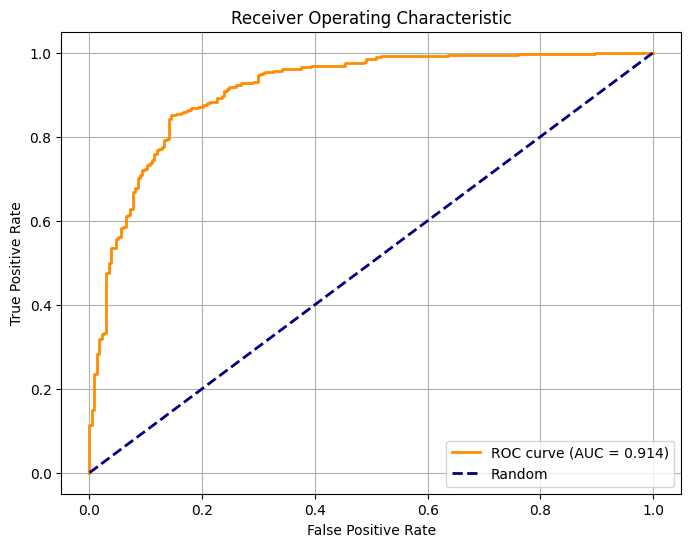

In [17]:
results = evaluate_model(model, test_dataloader)
print(f"Accuracy: {results['accuracy']:.4f}")
print(f"AUC: {results['auc']:.4f}")

In [31]:
!pip install grad_cam




[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


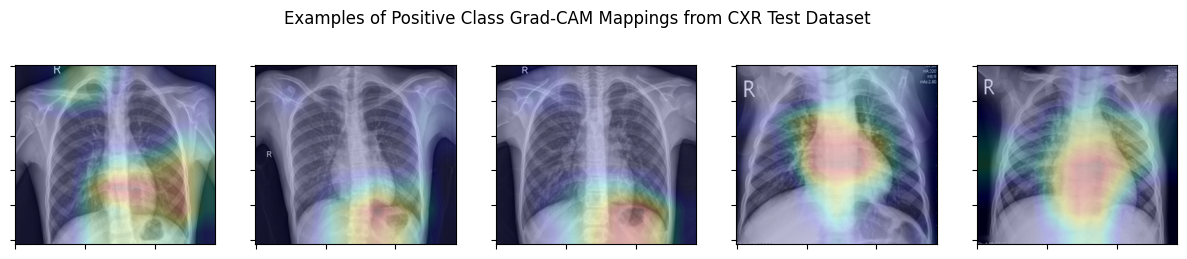

In [107]:

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils import model_targets

from pytorch_grad_cam.utils.image import show_cam_on_image

# For ResNet, typically target the last conv layer
target_layers = [model.get_activation_maps()]

cam = GradCAM(model=model, target_layers=target_layers)

def get_image_CAM(image_index):

    grayscale_cam = cam(input_tensor=test_dataset[image_index]['image'].unsqueeze(0), targets=None)  # targets=None will use argmax
    def prepare_grayscale_for_cam(image_tensor):
        """
        Converts a grayscale torch tensor of shape (1,H,W) to numpy array of shape (H,W,3) 
        normalized to [0,1] for show_cam_on_image
        
        Args:
            image_tensor (torch.Tensor): Input tensor of shape (1,H,W)
        
        Returns:
            numpy.ndarray: RGB numpy array of shape (H,W,3) with values in [0,1]
        """
        # Convert to numpy and move to CPU if needed
        if image_tensor.is_cuda:
            image_tensor = image_tensor.cpu()
        
        # Convert to numpy
        image_np = image_tensor.numpy()
        
        # Remove channel dimension
        image_np = image_np.squeeze(0)  # Now (H,W)
        
        # Normalize to [0,1] if needed
        if image_np.max() > 1:
            image_np = image_np / 255.0
            
        # Convert to RGB by repeating the channel
        image_rgb = np.stack([image_np] * 3, axis=-1)  # Now (H,W,3)
        
        return image_rgb

    np_image = prepare_grayscale_for_cam(test_dataset[image_index]['image'])




    #grayscale_cam = np.uint8(255 * grayscale_cam)

    # First squeeze and check
    grayscale_cam = grayscale_cam.squeeze(0)

    # Ensure values are finite and in correct range
    grayscale_cam = np.nan_to_num(grayscale_cam)  # Handle any NaN values
    grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min())

    return np_image, grayscale_cam

num_images = 5



selected_images_indices = [0, 20, 30, 410, 430]
image_CAM_pairs = [(np_image, grayscale_cam) for np_image, grayscale_cam in [get_image_CAM(i) for i in selected_images_indices]]



fig, ax = plt.subplots(1,num_images, figsize = (15, 3)) 

for i in range(0, num_images):

    np_image, grayscale_cam = image_CAM_pairs[i]


    ax[i].imshow(np_image)
    ax[i].imshow(grayscale_cam, cmap = 'jet', alpha = 0.2)

    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])



fig.suptitle("Examples of Positive Class Grad-CAM Mappings from CXR Test Dataset")
plt.show()

